In [1]:
from __future__ import print_function, division

import pymc3 as pm
import sys,os
import matplotlib as mpl
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy as sp
import scipy.stats as stats
from scipy.stats import norm, uniform

columnwidth = 342.2953 # value given by Latex
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

# Bayesian Probability Estimation

$ \newcommand{\thetavec}{\boldsymbol{\theta}} \newcommand{\pr}{\textrm{p}}$

1. Tossing Coins (to your Witcher)

    i. Numpy/Scipy
    
    ii. Pymc3 (Probabilistic Programming in Python)
    


2. Multivariate Linear Regression


3. ...Something Cool...

In this notebook we briefly review some of the basics of Bayesian inference and real-time updating with finite and changing data/observations. Based on these observations, we want to better attribute the probability density function that represents some physical model or mechanism. This notebook is tailored from thorough lessons given at OSU physics and can be found at: https://github.com/furnstahl

Bayes theorem is simply written as

\begin{equation}
    \pr(\thetavec | \text{data}, c) = \frac{\pr(\text{data} | \thetavec, c) \times \pr(\thetavec,c)}{\pr(\text{data}|c)}
\end{equation}

We have generalized with $c$ being some arbitrary list of parameters that define the true (unknown) model, but here are not accounted for. Unless your model is exact, there is always a term $c$ showing up as errors, noise, etc.

Ex 1. For example 1, we will have a weighted coin with Bernoulli probablity distribution on binary outcomes

\begin{equation}
    P(X=x) =
    \begin{cases}
      p \text{ for } x = 1\\
      1-p \text{ for } x = 0
    \end{cases} 
\end{equation}

Given a set of data generated from observing $N$ consecutive coin-flips, how can determine our certainty that the bias of the coin is $p$? $p = 0.5$ is the typical coin in our pocket, otherwise a very different coin. As each observation (data point) is independent we want to know that given this point and an initial guess as to what we think the coin is, how accurate is this? The outcomes of a weighted coin toss and Bernoulli function is

\begin{equation}
    P(\text{heads} (H), \text{tosses } (T) | p_h) = {H \choose T}p_h^T(1-p_h)^{T-H}
\end{equation}

Simple recipe for updating our guesses:

1. Uniform prior: $p(p_h) = \text{const.}$
2. Informed prior: $p(p_h) = \beta(p_h, \alpha, gamma)$
3. Uninformed prior: similar to [2]


For 1. we can update the posterior as

\begin{align}
    P(p_h | H, T) &\propto P(H, T | p_h) \\
    P(p_h | H, T) &\propto p_h^T(1-p_h)^{T-H}
\end{align}

Ensuring the posterior is normalized over integrating $p_h$ we then have

\begin{equation}
    P(p_h | H, T) =  \frac{\Gamma(2 + H)p_h^T(1-p_h)^{T-H}}{\Gamma(1 + H - T)\Gamma(1 + T)}
\end{equation}

As a notice, Beta probability density function is

\begin{equation}
    P(p_h, \alpha, \gamma) =  \frac{\Gamma(\alpha + \gamma)p_h^{1-\alpha}(1-p_h)^{1-\beta}}{\Gamma(\alpha)\Gamma(\beta)}
\end{equation}

The integral of the Bernouli distribution is the Beta function. Our update procedure for any arbitarty Beta distribution $\beta(p_h, \alpha, \gamma)$ given some dataset $T, H$ is just

\begin{equation}
    P(p_h | H, T) =  \frac{\beta(p_h, \alpha + H, \gamma + T - H)}{\int dp_h \beta(p_h, \alpha + H, \gamma + T - H)}
\end{equation}


Therefore we have the same update procedure for each guess as long as we provide a very informed initial guess. Whenever the conjugate distribution is well known, that suffices as a first guess and provides a simple update scheme.

1. Uniform: $\beta(p_h, 1, 1)$
2. Informed $\beta(p_h, 20, 20)$
3. Uninformed $\beta(p_h, 0.2, 0.2)$

In [31]:
x = np.linspace(0,1,301);
prob_heads = 0.2;
n_trials_max = 5000;
N = 1;

data = stats.bernoulli.rvs(prob_heads, size=n_trials_max)
num_heads = data[:N].sum();

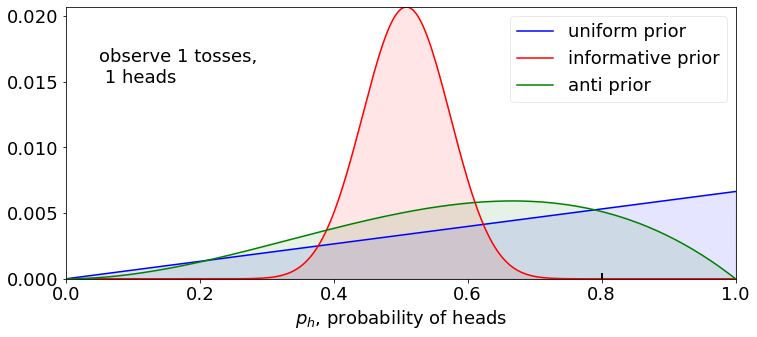

In [105]:
font_size = 18
plt.rcParams.update({'font.size': font_size})

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)


alpha_1=1.
beta_1=1.
alpha_2=30.
beta_2=30.
alpha_3=2.0
beta_3=2.0
        
heads = num_heads;
y_1 = stats.beta.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
y_2 = stats.beta.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
y_3 = stats.beta.pdf(x, alpha_3 + heads, beta_3 + N - heads)

y_1 /= y_1.sum()
y_2 /= y_2.sum()
y_3 /= y_3.sum()

# default y_3 distribution has two high max at endpoints for plot
y_max = np.max([y_1.max(), y_2.max()])  

line1, = ax.plot(x, y_1, label="uniform prior", color="blue")
ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
line2, = ax.plot(x, y_2, label="informative prior", color="red")
ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
line3, = ax.plot(x, y_3, label="anti prior", color="green")
ax.fill_between(x, 0, y_3, color="green", alpha=0.1)

ax.set_xlabel("$p_h$, probability of heads") 
#ax.set_yticks([])  # turn off the plotting of ticks on the y-axis
ax.axvline(prob_heads, 0, 1.1*y_max, color="k", linestyle="--", lw=2)
ax.annotate(f'observe {N:d} tosses,\n {heads:d} heads', 
            xy=(0.05,0.85), xycoords='axes fraction', 
            horizontalalignment='left',verticalalignment='top')
leg = ax.legend(loc='upper right')
leg.get_frame().set_alpha(0.4)
ax.autoscale(tight=True)

/var/folders/k7/9jypb0dx433fx7bbdx3xmwqm8x67ts/T/ipykernel_67383/355768074.py:19: RuntimeWarning: invalid value encountered in true_divide
  y_3 /= y_3.sum()
/var/folders/k7/9jypb0dx433fx7bbdx3xmwqm8x67ts/T/ipykernel_67383/355768074.py:45: RuntimeWarning: invalid value encountered in true_divide
  y_3 /= y_3.sum()
/var/folders/k7/9jypb0dx433fx7bbdx3xmwqm8x67ts/T/ipykernel_67383/355768074.py:45: RuntimeWarning: invalid value encountered in true_divide
  y_3 /= y_3.sum()


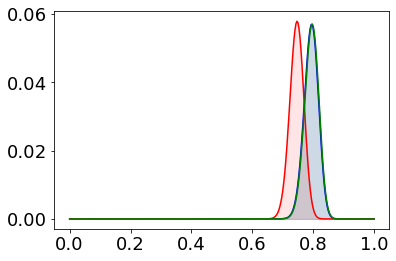

In [104]:
x = np.linspace(0, 1, 301);
prob_heads = 0.8;
n_trials_max = 5000;
data = stats.bernoulli.rvs(prob_heads, size=n_trials_max)

fig, ax = plt.subplots()
ax.axis([0,1.0,0.0,0.1])

init = 1;
N = init
num_heads = data[:N].sum();
heads = num_heads;
y_1 = stats.beta.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
y_2 = stats.beta.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
y_3 = stats.beta.pdf(x, alpha_3 + heads, beta_3 + N - heads)

y_1 /= y_1.sum()
y_2 /= y_2.sum()
y_3 /= y_3.sum()

line1.set_data(x, y_1);
line2.set_data(x, y_2);
line3.set_data(x, y_3);


line1, = ax.plot(x, y_1, label="uniform prior", color="blue")
ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
line2, = ax.plot(x, y_2, label="informative prior", color="red")
ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
line3, = ax.plot(x, y_3, label="anti prior", color="green")
ax.fill_between(x, 0, y_3, color="green", alpha=0.1)

def animate(i):
    N = init + i*3;
    
    num_heads = data[:N].sum();
    
    heads = num_heads;
    y_1 = stats.beta.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
    y_2 = stats.beta.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_3 = stats.beta.pdf(x, alpha_3 + heads, beta_3 + N - heads)

    y_1 /= y_1.sum()
    y_2 /= y_2.sum()
    y_3 /= y_3.sum()
    
    ax.cla();
    
    line1, = ax.plot(x, y_1, label="uniform prior", color="blue")
    ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    line2, = ax.plot(x, y_2, label="informative prior", color="red")
    ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
    line3, = ax.plot(x, y_3, label="anti prior", color="green")
    ax.fill_between(x, 0, y_3, color="green", alpha=0.1)
    
ani = FuncAnimation(plt.gcf(), animate, interval=500);


from IPython.display import HTML
HTML(ani.to_jshtml())

#plt.tight_layout()
#plt.show()

# Bayesian coin updates with numerics vs. analytics

The coin example above is a good example for some good ol'e analytic probability density functional forms and transformations. If you can find an analytic form for the PDF given some understanding of the physical problem, then that can make updating statistics from data infinitely easier.

Now, if we had no clue what was going on and wanted to update our estimates, how would we do that. Of course it still depends on coming up with a prior, but we need to parallize our estimate for each $p_h \in [0,1]$. Here we will use the Python package PyMC3. We are simplying using the code as presented in "https://towardsdatascience.com/conducting-bayesian-inference-in-python-using-pymc3-d407f8d934a5", so nothing special here. It is the same coin problem but now we have two different ways to go about it.



In [39]:
tosses = np.random.binomial(n=1, p=0.1, size=100)

with pm.Model() as model:
    theta = pm.Beta('theta', 2, 2)
    data = pm.Bernoulli('data', theta, observed=tosses)
    trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/szabo.48/bin/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

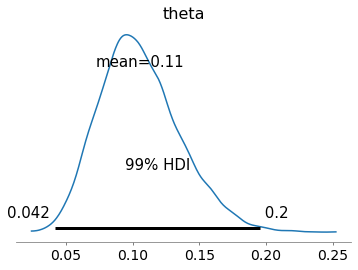

In [46]:
az.plot_posterior(trace, hdi_prob=0.99)

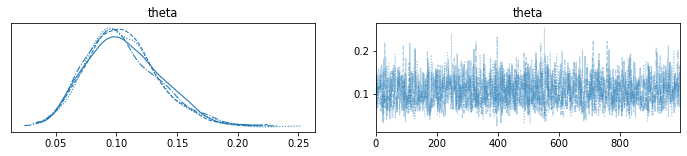

In [48]:
with model:
    az.plot_trace(trace)

It's very unclear exactly what PyMC3 is doing, we generated 100 random samples of coin flips and there is some stochastic sampling that occurs when building a "Model". So what is going on in this case.

PyMC3 model takes the 

# Multivariate Linear Regression


Now we have done a simple, one parameter estimation on a very manageable model. Let's try to tackle something with a few variables and noise, (we have some errors in the detection scheme that brought us the data). 

Let's fit a very simply line(s):

\begin{equation}
    z_t = \alpha_1 x_1 + \alpha_2 x_2 + \beta
\end{equation}

But we introduce random, Gaussian noise for our observations of the true value of $z$.

\begin{equation}
    z = \alpha_1 x_1 + \alpha_2 x_2 + \beta + \lambda N(0,\delta)
\end{equation}

Where $\lambda$ is an intensity and $\delta$ gives us the standard deviation. $N$ Is a Gaussian (normal) distribution centered about 0.

## Frequentist

We want to maximize the likelihood of our estimate $(\beta, \alpha_1, \alpha_2)$ provided the dataset $\bf{\vec{x},y}$. From a probability distribution perspective, we have $n$ independent observations (datapoints) so we can determine the overall probability of the dataset by multiplying each individual observation:

\begin{equation}
    \pr(\vec{x}_i,y_i | \beta, \alpha_1, \alpha_2) = \frac{1}{\sqrt{2\pi\lambda^2}}\exp{\frac{-(y_i - y(x_i, \vec{\theta}))^2}{2\lambda^2}}
\end{equation}

For the entire dataset, similar to the coin, the probability of all independent outcomes is

\begin{equation}
    \mathcal{L} = \pr(\vec{x},y | \beta, \alpha_1, \alpha_2) = \prod_i^n \pr(\vec{x}_i,y_i | \beta, \alpha_1, \alpha_2)
\end{equation}

It is subtle but we have dropped the indices on $x,y$. And as generically used, we use the log-likelihood as we can do simple addition.

\begin{equation}
    \log{\mathcal{L}} = -\frac{1}{2} \sum_i^n \log{2\pi\lambda^2} + \frac{(y_i - y(x_i, \vec{\theta}))^2}{2\lambda^2}
\end{equation}

1. We maximize the above function ($\frac{d\log{\mathcal{L}}}{dy}$) over the entire space of $(\alpha_1, \alpha_2, \beta)$ which will give us the optimal conditions.

2. Simple linear regression can also be cast as matrix product of output_vector = model times input_vector. Minimization in (1) is identical to inverting the "model" matrix.

If we wanted to perform a simple linear regression, we could simply perform some linear algebra and do some matrix inversions. Such is the frequentist perspective and we will see how this breaks down when we have very little "good" information regarding our observed data. Given our data of the form

\begin{align}
    X^T &=  \left[ \begin{array}{ccc}
        1 & 1 & ... & 1 \\
        x^1_1 & x^1_2 & ... & x^1_N \\
        x^2_1 & x^2_2 & ... & x^2_N  \end{array}\right] \\
    Z^T &=  \left[ \begin{array}{ccc}
        z_1 & z_2 & ... & z_N \end{array} \right] \\
    \Theta^T &=  \left[ \begin{array}{ccc}
        \beta & \alpha_1 & \alpha_2 \end{array} \right] \\
    \Theta_{\text{opt}} &= (X^TX)^{-1}(X^TZ)
\end{align}

We can estimate the errors from the covariance matrix and an estimated standard deviation extracted from the observed (noisy) data and our estimate of the truth.

\begin{equation}
    \Sigma = \left[ \begin{array}{ccc}
        \sigma_{\beta} & \sigma_{12} & \sigma_{13} \\
        \sigma_{21} & \sigma_{\alpha_2} & \sigma_{23} \\
        \sigma_{31} & \sigma_{32} & \sigma_3  \end{array}\right] = \sigma^2(X^TX)^{-1}
\end{equation}

In [188]:
def get_data(beta, alpha, samples=10, gamma = 5, amplitude=5.0, rseed=1984, uniform=True):
    """Given a multivariate linear expression defined by the dim(alpha),
       "sample" random points in the dim(alpha) space from x_i = 0 to 5.
       Gaussian (normal) noise added with amplitude/standard deviation "gamma".
       Return x_data and obs_data ==> obs_data(x_data, alpha, beta).
    """
    try:
        dim = len(alpha);
    except:
        print("Randomly sampling from a 1-dimensional system");
        dim = 1;
    
    if uniform == True:
        x_data =  np.random.normal(0, 1, size = (samples, dim));
        e = np.random.exponential(1.0, size=(samples, dim));
        norms = np.sum(x_data**2.0 + e, axis=1);
        inv_norm = 1.0/norms;

        for i in range(dim):
            x_data.T[i] = amplitude * inv_norm * x_data.T[i];
            
    else:
        x_data=np.random.rand(samples, dim);
    
    obs_data = x_data @ alpha + beta * np.ones([x_data.shape[0]]);
    obs_data += gamma * np.random.randn(samples)    # Add in Gaussian noise
    
    x_data = np.column_stack((np.ones(x_data.shape[0]), x_data));
    
    return x_data, obs_data, gamma * np.ones_like(obs_data)  # return coordinates and error bars


def log_likelihood(theta, x_data, obs_data, gamma):
    y_model = np.zeros_like(y);
    for i in range(len(theta)):
        y_model += theta[i] * x_data.T[i];

    return -0.5 * np.sum(np.log(2 * np.pi * gamma**2) + (obs_data - y_model)**2 / gamma**2)


def mini_reg(theta, x_data, obs_data, gamma):
    return -log_likelihood(theta, x, y, dy)

### Basic Scipy.optimization


Before doing the matrix algebra, we can simply define our loss function that needs minimization (simple linear regression) as the logarithm of the likelihood. We use scipy.optimize to the minimize our loss function and make an initial guess of parameters to be $(\beta, \alpha_1, \alpha_2) = (0,0,0)$.

      fun: -79.2457812201865
 hess_inv: array([[ 4.00688296e-06,  8.43811732e-07, -1.96584437e-07],
       [ 8.43811732e-07,  4.47739065e-06,  2.17650591e-07],
       [-1.96584437e-07,  2.17650591e-07,  9.29941003e-07]])
      jac: array([1.90734863e-06, 2.86102295e-06, 2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 9
     njev: 23
   status: 0
  success: True
        x: array([1.00112568, 2.99740546, 0.79795879])


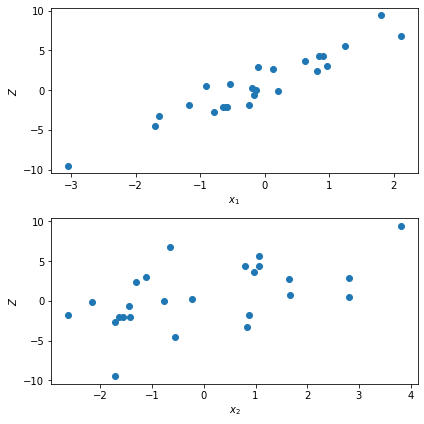

In [190]:
beta = 1.0;
alpha = [3.0, 0.8];
x, y, dy = get_data(beta, alpha, samples = 25, gamma=0.01, rseed=1984)

fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].errorbar(x.T[1], y, dy, fmt='o')
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$Z$")

ax[1].errorbar(x.T[2], y, dy, fmt='o')
ax[1].set_xlabel(r"$x_2$")
ax[1].set_ylabel(r"$Z$")
fig.tight_layout()

result = optimize.minimize(mini_reg, x0=[0, 0, 0], args=(x, y, dy))
print(result)

      fun: 48.80722112645477
 hess_inv: array([[ 0.12473153, -0.00849666, -0.00217888],
       [-0.00849666,  0.03250052,  0.00514291],
       [-0.00217888,  0.00514291,  0.06877839]])
      jac: array([0.00000000e+00, 9.53674316e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.91718161, 3.23496628, 0.6720335 ])


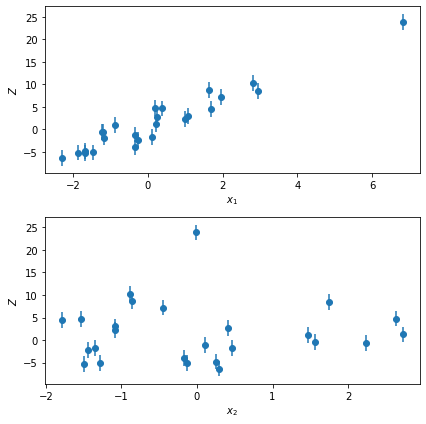

In [191]:
beta = 1.0;
alpha = [3.0, 0.8];
x, y, dy = get_data(beta, alpha, samples = 25, gamma=1.75, rseed=1984)

fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].errorbar(x.T[1], y, dy, fmt='o')
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$Z$")

ax[1].errorbar(x.T[2], y, dy, fmt='o')
ax[1].set_xlabel(r"$x_2$")
ax[1].set_ylabel(r"$Z$")
fig.tight_layout()

result = optimize.minimize(mini_reg, x0=[0, 0, 0], args=(x, y, dy))
print(result)

In [307]:
np.linalg.inv(x.T @ x) @ x.T @ y

array([1.03617081, 3.00102836, 0.73665743])

We see above that we get the same results if we had used very simple linear algebra vs. the scipy.minimize function. All the same...



## Bayesian

We will do the Bayesian posterior estimation the same way as before. We are essentially following along https://arxiv.org/pdf/1411.5018.pdf but with one more dimension to our function $z(x_1, x_2; \vec{\alpha}, \beta)$. Next we want to determine the posterior distribution from the likelihood function we have already assigned (and work to minimized) and along with the prior. We are essentially bolstering our confidence on the likelihood by including information about the data distribution.

\begin{equation}
    \pr(\{\beta, \alpha_1, \alpha_2\} | \{x,y\}) \propto \pr(\{x,y\} | \{\beta, \alpha_1, \alpha_2\}) \pr(\{\beta, \alpha_1, \alpha_2\})
\end{equation}

Or we can work with logarithms and simply add the log-likelihood and the log-prior:

\begin{equation}
    \log[\pr(\{\beta, \alpha_1, \alpha_2\} | \{x,y\})] \propto \log[\pr(\{x,y\} | \{\beta, \alpha_1, \alpha_2\})] +  \log[\pr(\{\beta, \alpha_1, \alpha_2\})]
\end{equation}

Usinging the same log-likelihood that we originally used in the frequentist example we can see how the Bayesian approach is different(same). If we pick a uniform prior $\pr(\alpha, \beta) \propto 1$, then the Bayesian approach is identical to the frequentist. If we are able to generate any insight into how the data is generated, or how we expect the distribution to behave, then we can get better refine the uncertainties in our estimates. 

We will work with two prior distributions:

1. Flat prior with uniform expectation for all values of $\beta, \alpha_1, \alpha_2$.

2. Informed prior (https://arxiv.org/pdf/1411.5018.pdf) and recreated for multivariables.

To unpack the informed prior, we know that $y = \alpha x + \beta$ could easily be rewritten as $x = y/\alpha - beta/\alpha$. Because the problem could have been solved either way, the answer should similarly be symmetric and the probability density function should be invarian under the change of variables. In this case we have $(\alpha^\prime, \beta^\prime) = (1/\alpha, -\beta/\alpha). The transformation for such is 


\begin{align}
    \left[ \begin{array}{ccc}
        \beta^\prime \\ \alpha^\prime \end{array} \right] &=  \left[ \begin{array}{ccc}
        -1/\alpha & 0 \\
        0 & 1/\alpha^2 \end{array}\right] \left[ \begin{array}{ccc}
        \beta \\ \alpha \end{array} \right] \\
\end{align}

The determinant of this transformation matrix is $\propto \alpha^{-3}$. The Fisher Information is proportional to the square of this Jacobian matrix (https://en.wikipedia.org/wiki/Jeffreys_prior) and we want to normalize the probability distribution such that it is proportional to the information. If this is the case, than transforming the density into any basis will leave the information density unchanged. A function that satisfies this constraint as presented in the afformentioned ArXiv work and Prof. Furnstahl's github blog: https://github.com/furnstahl/Physics-8805/blob/master/topics/bayesian-parameter-estimation/parameter_estimation_fitting_straight_line_I.ipynb.

\begin{equation}
    \pr(\alpha, \beta) = (1 + \alpha^2)^{-3/2}
\end{equation}

Now to perform the same transformation for the multivariate case. Here we could have transformed the problem identically for both $x_1, x_2$ vectors. Doing the transformation for $x_1$ we have the matrix:

\begin{align}
    y &= \alpha_1 x_1 + \alpha_2 x_2 + \beta \\
    x_1 &= y/\alpha_1 - \alpha_2 x_2 / \alpha_1 -\beta/\alpha_1 \\
    x_2 &= y/\alpha_2 - \alpha_1 x_1 / \alpha_2 -\beta/\alpha_2 \\
    \left[ \begin{array}{ccc}
        \beta^\prime \\ \alpha_1^\prime \\ \alpha_2^\prime \end{array} \right] &=  \left[ \begin{array}{ccc}
        -1/\alpha_1 & 0 & 0\\
        0 & 1/\alpha_1^2 & 0 \\
        0 & 0 & -1/\alpha_1 \end{array}\right] \left[ \begin{array}{ccc}
        \beta \\ \alpha_1 \\ \alpha_2 \end{array} \right] \\
\end{align}

The Jacobian of this matrix is $\propto 1/\alpha^{-4}$. This is true for both $\alpha_1, \alpha_2$ so the function we choose as our prior is 

\begin{equation}
    \pr(\alpha_1, \alpha_2, \beta) = (1 + \alpha_1^2, \alpha_2^2)^{-2}
\end{equation}

This is an uninformed prior that captures the inherent symmetry in the problem, solving for $x$ or $y$. In what follows we will compare the Frequentist and Bayesian approach and the 2D contours for different pairs of variables. The top plots will be the Frequentist approach (uniform distribution) and the second row will be Baysian (uninformed).

In [260]:
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -2.0 * np.log(1 + theta[1]**2 + theta[2]**2)
    else:
        return -np.inf  # log(0)
    
def contour_levels(grid):
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997])**2)
    return np.sort(sorted_[cutoffs])

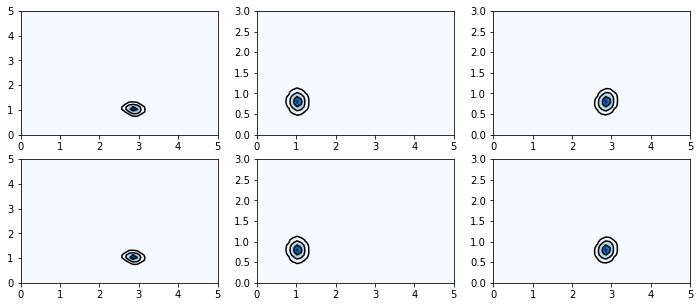

In [245]:
beta = 1.0;
alpha = [3.0, 0.8];
x, y, dy = get_data(beta, alpha, samples = 25, gamma=0.5, rseed=1984)

slope_limits = (0, 5);
intercept_limits = (0, 3);

slope_range = np.linspace(*slope_limits)
intercept_range = np.linspace(*intercept_limits)

log_P1 = [[[log_likelihood([b, m1, m2], x, y, dy) + log_flat_prior([b, m1, m2])
           for m1 in slope_range] for m2 in slope_range] for b in intercept_range]
log_P2 = [[[log_likelihood([b, m1, m2], x, y, dy) + log_symmetric_prior([b, m1, m2])
           for m1 in slope_range] for m2 in slope_range] for b in intercept_range]

P1 = np.exp(log_P1 - np.max(log_P1))
P2 = np.exp(log_P2 - np.max(log_P2))

fig, ax = plt.subplots(2, 3, figsize=(12, 5),
                       sharex=False, sharey=False)

#ax[0].plot(slope_range, np.sum(P1,axis=(1,2)))
#ax[1].plot(slope_range, np.sum(P1,axis=(0,2)))
#ax[2].plot(slope_range, np.sum(P1,axis=(0,1)))


ax[0,0].contourf(slope_range, slope_range, np.sum(P1,axis=0), 100, cmap='Blues')
ax[0,0].contour(slope_range, slope_range, np.sum(P1,axis=0), contour_levels(np.sum(P1,axis=0)), 
                  colors='black')

ax[0,1].contourf(slope_range, intercept_range, np.sum(P1,axis=2), 100, cmap='Blues')
ax[0,1].contour(slope_range, intercept_range, np.sum(P1,axis=2), contour_levels(np.sum(P1,axis=2)), 
                  colors='black')

ax[0,2].contourf(slope_range, intercept_range, np.sum(P1,axis=1), 100, cmap='Blues')
ax[0,2].contour(slope_range, intercept_range, np.sum(P1,axis=1), contour_levels(np.sum(P1,axis=1)), 
                  colors='black')


ax[1,0].contourf(slope_range, slope_range, np.sum(P2,axis=0), 100, cmap='Blues')
ax[1,0].contour(slope_range, slope_range, np.sum(P2,axis=0), contour_levels(np.sum(P2,axis=0)), 
                  colors='black')

ax[1,1].contourf(slope_range, intercept_range, np.sum(P2,axis=2), 100, cmap='Blues')
ax[1,1].contour(slope_range, intercept_range, np.sum(P2,axis=2), contour_levels(np.sum(P1,axis=2)), 
                  colors='black')

ax[1,2].contourf(slope_range, intercept_range, np.sum(P2,axis=1), 100, cmap='Blues')
ax[1,2].contour(slope_range, intercept_range, np.sum(P2,axis=1), contour_levels(np.sum(P2,axis=1)), 
                  colors='black')

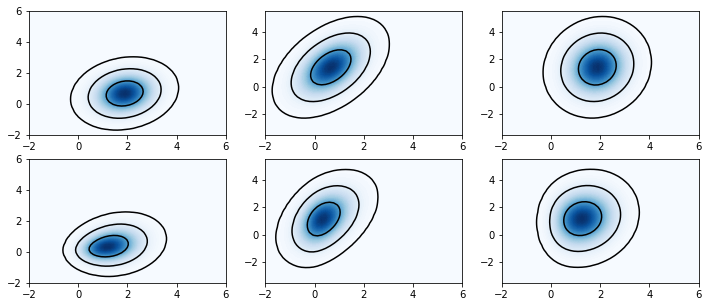

In [259]:
beta = 1.0;
alpha = [3.0, 0.8];
x, y, dy = get_data(beta, alpha, samples = 40, gamma=6.5, rseed=1984)

slope_limits = (-2, 6);
intercept_limits = (-3.5, 5.5);

slope_range = np.linspace(*slope_limits)
intercept_range = np.linspace(*intercept_limits)

log_P1 = [[[log_likelihood([b, m1, m2], x, y, dy) + log_flat_prior([b, m1, m2])
           for m1 in slope_range] for m2 in slope_range] for b in intercept_range]
log_P2 = [[[log_likelihood([b, m1, m2], x, y, dy) + log_symmetric_prior([b, m1, m2])
           for m1 in slope_range] for m2 in slope_range] for b in intercept_range]

P1 = np.exp(log_P1 - np.max(log_P1))
P2 = np.exp(log_P2 - np.max(log_P2))

fig, ax = plt.subplots(2, 3, figsize=(12, 5),
                       sharex=False, sharey=False)

#ax[0].plot(slope_range, np.sum(P1,axis=(1,2)))
#ax[1].plot(slope_range, np.sum(P1,axis=(0,2)))
#ax[2].plot(slope_range, np.sum(P1,axis=(0,1)))


ax[0,0].contourf(slope_range, slope_range, np.sum(P1,axis=0), 100, cmap='Blues')
ax[0,0].contour(slope_range, slope_range, np.sum(P1,axis=0), contour_levels(np.sum(P1,axis=0)), 
                  colors='black')

ax[0,1].contourf(slope_range, intercept_range, np.sum(P1,axis=2), 100, cmap='Blues')
ax[0,1].contour(slope_range, intercept_range, np.sum(P1,axis=2), contour_levels(np.sum(P1,axis=2)), 
                  colors='black')

ax[0,2].contourf(slope_range, intercept_range, np.sum(P1,axis=1), 100, cmap='Blues')
ax[0,2].contour(slope_range, intercept_range, np.sum(P1,axis=1), contour_levels(np.sum(P1,axis=1)), 
                  colors='black')


ax[1,0].contourf(slope_range, slope_range, np.sum(P2,axis=0), 100, cmap='Blues')
ax[1,0].contour(slope_range, slope_range, np.sum(P2,axis=0), contour_levels(np.sum(P2,axis=0)), 
                  colors='black')

ax[1,1].contourf(slope_range, intercept_range, np.sum(P2,axis=2), 100, cmap='Blues')
ax[1,1].contour(slope_range, intercept_range, np.sum(P2,axis=2), contour_levels(np.sum(P1,axis=2)), 
                  colors='black')

ax[1,2].contourf(slope_range, intercept_range, np.sum(P2,axis=1), 100, cmap='Blues')
ax[1,2].contour(slope_range, intercept_range, np.sum(P2,axis=1), contour_levels(np.sum(P2,axis=1)), 
                  colors='black')

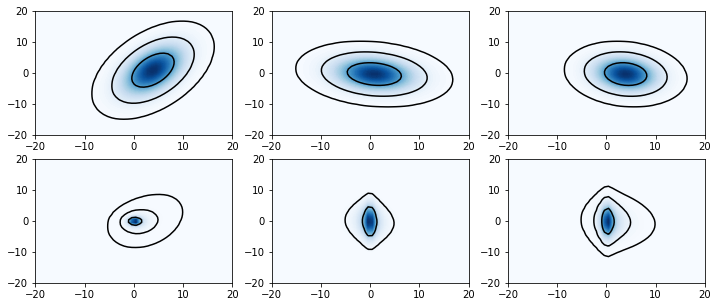

In [258]:
beta = 1.0;
alpha = [3.0, 0.8];
x, y, dy = get_data(beta, alpha, samples = 4, gamma=6.5, rseed=1984)

slope_limits = (-20, 20);
intercept_limits = (-20, 20);

slope_range = np.linspace(*slope_limits)
intercept_range = np.linspace(*intercept_limits)

log_P1 = [[[log_likelihood([b, m1, m2], x, y, dy) + log_flat_prior([b, m1, m2])
           for m1 in slope_range] for m2 in slope_range] for b in intercept_range]
log_P2 = [[[log_likelihood([b, m1, m2], x, y, dy) + log_symmetric_prior([b, m1, m2])
           for m1 in slope_range] for m2 in slope_range] for b in intercept_range]

P1 = np.exp(log_P1 - np.max(log_P1))
P2 = np.exp(log_P2 - np.max(log_P2))

fig, ax = plt.subplots(2, 3, figsize=(12, 5),
                       sharex=False, sharey=False)

#ax[0].plot(slope_range, np.sum(P1,axis=(1,2)))
#ax[1].plot(slope_range, np.sum(P1,axis=(0,2)))
#ax[2].plot(slope_range, np.sum(P1,axis=(0,1)))


ax[0,0].contourf(slope_range, slope_range, np.sum(P1,axis=0), 100, cmap='Blues')
ax[0,0].contour(slope_range, slope_range, np.sum(P1,axis=0), contour_levels(np.sum(P1,axis=0)), 
                  colors='black')

ax[0,1].contourf(slope_range, intercept_range, np.sum(P1,axis=2), 100, cmap='Blues')
ax[0,1].contour(slope_range, intercept_range, np.sum(P1,axis=2), contour_levels(np.sum(P1,axis=2)), 
                  colors='black')

ax[0,2].contourf(slope_range, intercept_range, np.sum(P1,axis=1), 100, cmap='Blues')
ax[0,2].contour(slope_range, intercept_range, np.sum(P1,axis=1), contour_levels(np.sum(P1,axis=1)), 
                  colors='black')


ax[1,0].contourf(slope_range, slope_range, np.sum(P2,axis=0), 100, cmap='Blues')
ax[1,0].contour(slope_range, slope_range, np.sum(P2,axis=0), contour_levels(np.sum(P2,axis=0)), 
                  colors='black')

ax[1,1].contourf(slope_range, intercept_range, np.sum(P2,axis=2), 100, cmap='Blues')
ax[1,1].contour(slope_range, intercept_range, np.sum(P2,axis=2), contour_levels(np.sum(P1,axis=2)), 
                  colors='black')

ax[1,2].contourf(slope_range, intercept_range, np.sum(P2,axis=1), 100, cmap='Blues')
ax[1,2].contour(slope_range, intercept_range, np.sum(P2,axis=1), contour_levels(np.sum(P2,axis=1)), 
                  colors='black')

## Understanding the Baysian results

1. In the first example we used a variance much less than the parameters used in the model $\lambda << \alpha_1, \alpha_2, \beta$. In doing so and having a good number of data points, we see that both the frequentist and Bayesian approach provide extremely tight fits (1-3 sigma) and for all intents and purposes are equal.

2. Generating a bit more data and cranking up the noise, we see that the two approaches begin to deviate slightly from one another. In the first column we see that the spread along the y-axis is slightly reduced in the Bayesian approach. The other two plots for the most part are similar. For $\lambda > \alpha_1$ it becomes increasingly difficult to estimate this value, and the uninformed prior provides a stronger estimate with large noise.

3. Here we use the same amplitude noise but limit the observations to just 4 data points. Here we see a huge different in the sigma contours. Accross all plots we see that the Bayesian approach provides an extremely narrowed distribution on the data, with the 1-sigma confidence interval being almost half the width as the frequentist perspective.



# Bayesian calculation using PyMC3

We will fit the same data using the standard PyMC package. Following along with (https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html), but we will use our own very simple PDF for the slope as above...

In [322]:
x, y, dy = get_data(1.0, [3.0, 0.8], samples = 25, gamma=0.5, rseed=23245243)

In [323]:
basic_model = pm.Model()

with basic_model:

    beta = pm.Uniform('beta', -100, 100);
    sigma = pm.HalfNormal("sigma", sigma=1);

    def log_alpha(value=0):
        return -2.0 * np.log(1 + value**2);
    
    alpha = pm.DensityDist("alpha", logp = log_alpha, shape=2);
    
    mu = beta * x.T[0] + alpha[0] * x.T[1] + alpha[1] * x.T[2];

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y);

In [324]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'beta_interval__': array(0.02203044),
 'sigma_log__': array(-0.82678632),
 'alpha': array([2.94407776, 0.7287257 ]),
 'beta': array(1.10147734),
 'sigma': array(0.43745286)}

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [sigma]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 155 seconds.


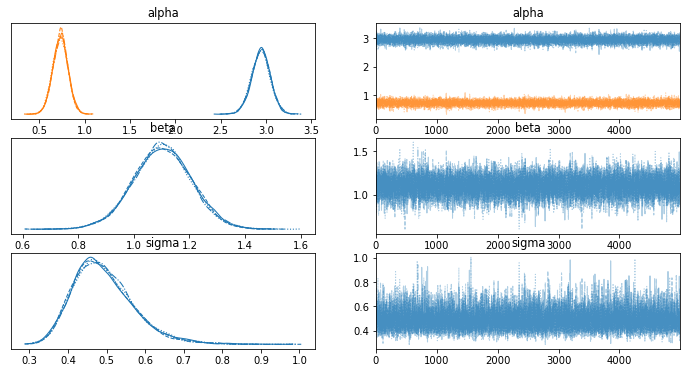

In [325]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(5000, step=step, return_inferencedata=False)
    
with basic_model:
    az.plot_trace(trace);

In [326]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.94,0.10,2.75,3.14,0.0,0.0,14378.04,14169.41,1.0
alpha[1],0.73,0.08,0.58,0.89,0.0,0.0,12865.63,11752.16,1.0
beta,1.10,0.11,0.90,1.30,0.0,0.0,15169.82,12965.80,1.0
sigma,0.49,0.08,0.35,0.64,0.0,0.0,13705.75,12797.56,1.0


In [336]:
x, y, dy = get_data(1.0, [3.0, 0.8], samples = 10, gamma=6.5, rseed=4255);

basic_model = pm.Model()

with basic_model:

    beta = pm.Uniform('beta', -100, 100);
    sigma = pm.HalfNormal("sigma", sigma=5);

    def log_alpha(value=0):
        return -2.0 * np.log(1 + value**2);
    
    alpha = pm.DensityDist("alpha", logp = log_alpha, shape=2);
    
    mu = beta * x.T[0] + alpha[0] * x.T[1] + alpha[1] * x.T[2];

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y);
    
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'beta_interval__': array(0.01180749),
 'sigma_log__': array(1.90691543),
 'alpha': array([0.28214343, 0.15557858]),
 'beta': array(0.59036752),
 'sigma': array(6.73229054)}

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [sigma]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


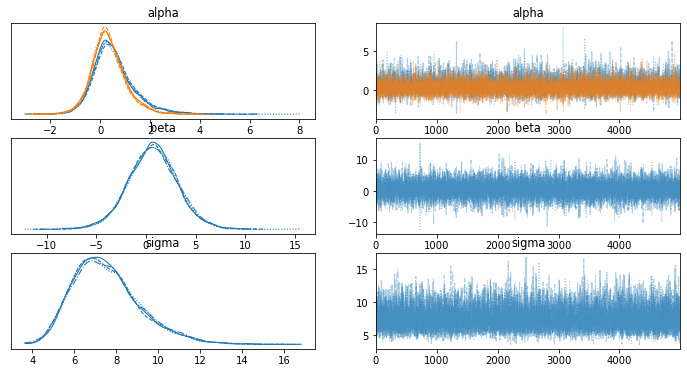

In [337]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(5000, step=step, return_inferencedata=False)
    
with basic_model:
    az.plot_trace(trace);

In [338]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.55,0.85,-0.92,2.25,0.01,0.01,16563.57,12281.90,1.0
alpha[1],0.34,0.69,-0.93,1.70,0.01,0.01,13634.29,10048.72,1.0
beta,0.67,2.50,-3.90,5.55,0.02,0.02,18600.81,13495.75,1.0
sigma,7.54,1.62,4.83,10.73,0.01,0.01,13869.92,13758.92,1.0
